# Multi-Class Produce Classification

This notebook builds and demonstrates a multi-class image classifier using TensorFlow 2 and TensorFlow Hub

## 1. Problem
Identifying the type of produce provided an image of the fruit or vegetable.

## 2. Data
The data used is a subset of the Fruits360 dataset available on Kaggle.
https://www.kaggle.com/datasets/moltean/fruits

The data consists of images sorted into directories where the directory name is the label.
Since the images are unstructured data, a deep learning model will be used.
There are 11 classes in our dataset, including multiple types of apple.

### Acknowledgements:
https://www.photosforclass.com # Source of original 'user submitted photos'

https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition # Source of supplementary photos used to train an example model with enhanced effectiveness on user-submitted photos.

https://www.udemy.com/course/complete-machine-learning-and-data-science-zero-to-mastery/ # Techniques and code were adapted from this tutorial.


# Imports
These imports are required to run the notebook.

In [1]:
# Imports for UI elements
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Checkbox, Dropdown
import ipywidgets as widgets

# Get current working directory path
import os
cwd = os.getcwd()

# Import for working with paths
from pathlib import Path

# Import to allow timestamp generation
import datetime

# Import allows clearing output for cells
from IPython.display import clear_output

# Import numpy for data preparation
import numpy as np

# Import to allow transfer learning
import tensorflow_hub as hub
print("TensorFlow Hub version:", hub.__version__)

# Import to allow use of tensorflow for model creation and training
import tensorflow as tf

# Import to allow generation of plots and visuals
import matplotlib.pyplot as plt

# Imports for generating confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


TensorFlow Hub version: 0.12.0


# Settings:
Here are some initial settings that dictate what sections of notebook code will execute


In [2]:
# Contains UI interfaces for notebook settings



# Creates checkbox to select option to load pre-trained model rather than train new model
should_load_saved_model = True

def set_load_saved_model(checkbox):
    global should_load_saved_model
    should_load_saved_model = checkbox['owner'].value
    print_settings()


toggle_load_checkbox = widgets.Checkbox(value=True,
                                        description='Load pre-trained model',
                                        disabled=False,
                                        indent=False)

toggle_load_checkbox.observe(set_load_saved_model)

# Creates dropdown to select the model to load
selected_model_name = os.listdir(cwd + "\models\\")[-1]

model_selector = widgets.Dropdown(
                        options=os.listdir(cwd + "\models\\"),
                        value=os.listdir(cwd + "\models\\")[-1],
                        description='Selected saved model: ',
                        disabled=False,
                        style={'description_width': 'initial'})

def select_model(dropdown):
    global selected_model_name
    selected_model_name = dropdown['owner'].value
    print_settings()
   


model_selector.observe(select_model)

NUM_EPOCHS = 100

epoch_slider = IntSlider(min=10, max=100, step=10, value=100, description='Number of Epochs: ', style={'description_width': 'initial'}, layout=widgets.Layout(width='40%'))

def on_change(val):
    global NUM_EPOCHS
    NUM_EPOCHS = val['new']
    print_settings()
    
epoch_slider.observe(on_change, names='value')



# Prints current settings
def print_settings():
    clear_output()
    display(toggle_load_checkbox)
    display(model_selector)
    print("Model Training Parameters:")
    display(epoch_slider)
    print("Current Settings:")
    print("Will load model: " + str(should_load_saved_model))
    print("Will train model: " + str((not should_load_saved_model)))
    print("Current selected model: " + selected_model_name)
    print("Number of Training Epochs: " + str(NUM_EPOCHS))

print_settings()

Checkbox(value=True, description='Load pre-trained model', indent=False)

Dropdown(description='Selected saved model: ', options=('20230213-152303.h5',), style=DescriptionStyle(descrip…

Model Training Parameters:


IntSlider(value=100, description='Number of Epochs: ', layout=Layout(width='40%'), min=10, step=10, style=Slid…

Current Settings:
Will load model: True
Will train model: False
Current selected model: 20230213-152303.h5
Number of Training Epochs: 100


## Data Preparation


In [3]:
# Create links to paths of each data set

train_data_path = Path(cwd + "/Training")
val_data_path = Path(cwd + "/Validation")
test_data_path = Path(cwd + "/Test")
user_data_path = Path(cwd + "/User-Submissions")

#  Create list of image paths for each data set
train_image_paths = list(map(lambda x: str(x), list(train_data_path.glob('*/*'))))
val_image_paths = list(map(lambda x: str(x), list(val_data_path.glob('*/*'))))
test_image_paths = list(map(lambda x: str(x), list(test_data_path.glob('*/*'))))
user_image_paths = list(map(lambda x: str(x), list(user_data_path.glob('*'))))

# Method to get label from image path
def label_from_path(image_path):
    directory = os.path.dirname(image_path)
    return os.path.basename(directory)

# Get labels for each data set
train_labels = list(map(lambda x: label_from_path(x), train_image_paths))
val_labels = list(map(lambda x: label_from_path(x), val_image_paths))
test_labels = list(map(lambda x: label_from_path(x), test_image_paths))


# Get list of unique labels
unique_labels = np.unique(train_labels)

# Convert each label to be an array of booleans
train_bool_labels = [label == unique_labels for label in train_labels]
val_bool_labels = [label == unique_labels for label in val_labels]
test_bool_labels = [label == unique_labels for label in test_labels]

# Function to turn each image into a Tensor


# Default image size 
IMG_SIZE = 224

# Returns tensor of image_size from image.
def image_to_tensor(path_to_image, image_size=IMG_SIZE):
    # Load the image
    image = tf.io.read_file(path_to_image)
    # Convert the image into a Tensor
    image_tensor = tf.image.decode_jpeg(image, channels=3)
    # Get RGB values normalized from 0-255 to 0-1
    image_tensor = tf.image.convert_image_dtype(image_tensor, tf.float32)
    # Resize the image to be a square of image_size
    image_tensor = tf.image.resize(image_tensor, size=[image_size, image_size])
    
    return image_tensor
    

# Get labeled image, returning the image_tensor, label as a tuple
def get_labeled_image_tensor(path, label):
    tensor = image_to_tensor(path)
    return tensor, label
    

# Create Batches from data

# Batch size setting:
BATCH_SIZE = 64

# Returns batches from data
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, is_validation_data=False, is_test_data=False):

    if is_test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(image_to_tensor).batch(batch_size)
        return data_batch
    elif is_validation_data:
        print("Creating valdiation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                  tf.constant(y)))
        data_batch = data.map(get_labeled_image_tensor).batch(batch_size)
        return data_batch
    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                  tf.constant(y)))
        # Shuffle paths and labels
        data = data.shuffle(buffer_size=len(X))
        data = data.map(get_labeled_image_tensor)
        data_batch = data.batch(batch_size)
    return data_batch

# Create training and validation batches
train_data_batch = create_data_batches(train_image_paths, train_bool_labels)
val_data_batch = create_data_batches(val_image_paths, val_bool_labels, is_validation_data=True)
test_data_batch = create_data_batches(test_image_paths, test_bool_labels, is_test_data=True)
user_data_batch = create_data_batches(user_image_paths, is_test_data=True)

Creating training data batches...
Creating valdiation data batches...
Creating test data batches...
Creating test data batches...


# Loading or Training and Saving a Model

In [4]:
# Initial Model Setup

# Define input shape, output shape, and model URL from TensorFlow Hub
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, h, w, color channels
OUTPUT_SHAPE = len(unique_labels)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"


# Returns a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Transfer learning using:", MODEL_URL)

    # Specifies Keras sequential model, input layer, and output layer using softmax activation
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL),
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                              activation="softmax")
    ])

    # Compiles the model using Adam optimizer and accuracy metric
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    # Builds the model to process the given input shape
    model.build(INPUT_SHAPE)

    return model

# Stops training early if accuracy stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience = 3)

# Loading the Model

# Returns a saved, pre-trained model
def load_model(path_to_model):
    print(f"Retrieving model from: {path_to_model}")
    model = tf.keras.models.load_model(path_to_model,
                                      custom_objects = {"KerasLayer":hub.KerasLayer})
    return model
    

# Trains and returns a trained model
def train_model():

    # Create a model
    model = create_model()

    # Fit the model while using callbacks to stop early
    model.fit(x=train_data_batch,
            epochs=NUM_EPOCHS,
            validation_data = val_data_batch,
            validation_freq=1,
            callbacks=[early_stopping])
  
    # Return the fitted model
    return model

# If user selected options to load a model, load that model. Otherwise train a model.
if should_load_saved_model:
    model = load_model(cwd + "\models\\" + selected_model_name)
    print("Loading model: " + cwd + "\models\\" + selected_model_name)
else:
    model = train_model()


# Saving the Model

# Saves a copy of the model in the model directory, labeling it with a suffix.
def save_model(model, suffix=None):
    # Prepare save location
    save_path = os.path.join(cwd + "\models\\",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    if suffix:
        save_path += "-" + suffix + ".h5"
    else:
        save_path += ".h5"
    print(f"Saving model to : {save_path}...")
    model.save(save_path)
    return save_path

# If the user chose to train a model, save the trained model now.
if should_load_saved_model == False:
    save_model(model)

Retrieving model from: C:\Users\mklapper\Produce_Identifier\models\20230213-152303.h5
Loading model: C:\Users\mklapper\Produce_Identifier\models\20230213-152303.h5


# Predictions and Visuals Methods

In [5]:
# Returns the predicted label from an array of prediction probabilities
def get_predicted_label(prediction_probabilities):
    return unique_labels[np.argmax(prediction_probabilities)]

# Returns separate arrays of images and labels extracted from a batched dataset of Tensors
def extract_from_batch(data):
    images = []
    labels = []
    
    # Check if data has labels, take appropriate actions
    if type(data.as_numpy_iterator().next()) is tuple:
        # Loop through the data, populating arrays of images and labels
        for image, label in data.unbatch().as_numpy_iterator():
            images.append(image)
            labels.append(unique_labels[np.argmax(label)])
    else:
        # Just populate images
        for image in data.unbatch().as_numpy_iterator():
            images.append(image)
            
    return images, labels

# Displays 12 images and their labels from a data batch
def display_batch_images(image_tensors, label_bool_arrays):
    plt.figure(figsize=(10,10))
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_tensors[i])
        plt.title(unique_labels[label_bool_arrays[i].argmax()])
        plt.axis("off")

# Displays an image, predicted label, prediction confidence, and true label for image sample n of prediciton_probabilities
def display_prediction(prediction_probabilities, images, n=0, labels=None):
    # Get the prediction probabilities, and image for sample n
    pred_prob, image = prediction_probabilities[n], images[n]

    # Get the predicted label from the prediction probabilities for sample n
    pred_label = get_predicted_label(pred_prob)

    # Plot image for sample n & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    true_label = "Not_Provided"
    color = "black"
    
    if labels is not None:
        # Change the color of the title green to indicate if the prediction is right or wrong
        true_label = labels[n]
        if pred_label == true_label:
            color = "green"
        else:
            color = "red"

    # Change plot title to be predicted, confidence of prediction, and true label
    plt.title("Predicted: {} Confidence: {:2.0f}% Actual: {}".format(pred_label, 
                                      np.max(pred_prob)*100, 
                                      true_label),
                                      color=color)
  

# Display the top num_to_show predictions for sample with selected prediction_index
def display_top_predictions(prediction_probabilities, prediction_index=0, num_to_show=5, labels=None):
    
    pred_prob = prediction_probabilities[prediction_index]

    # Get the predicted label
    pred_label = get_predicted_label(pred_prob)

    # Find the top num_to_show prediction confidence interval indexes
    top_N_prediction_indexes = pred_prob.argsort()[-num_to_show:][::-1]

    # Find the top num_to_show prediction confidence values
    top_N_pred_values = pred_prob[top_N_prediction_indexes]

    # Find the top num_to_show prediction labels
    top_N_pred_labels = unique_labels[top_N_prediction_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_N_pred_labels)),
                       top_N_pred_values,
                       color="grey")
    plt.xticks(np.arange(len(top_N_pred_labels)),
               labels=top_N_pred_labels,
               rotation="vertical")
    if labels is not None:
        true_label = labels[prediction_index]
        # Change color of true label
        if np.isin(true_label, top_N_pred_labels):
            top_plot[np.argmax(top_N_pred_labels == true_label)].set_color("green")
        else:
            pass

def display_prediction_analysis(predictions, images, sample_num, labels=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    display_prediction(prediction_probabilities = predictions,
             images=images,
             n=sample_num,
             labels = labels)
    plt.subplot(1,2,2)
    display_top_predictions(predictions, sample_num, 5, labels)
    plt.tight_layout(h_pad=1.0)
    plt.show()


# Visuals

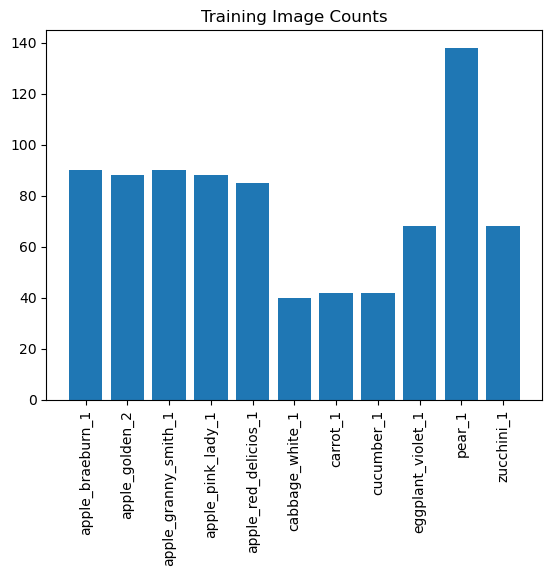

In [6]:
# Show count of training images for each classification label
train_label_counts  = {}
for label in train_labels:
    if label in train_label_counts:
        train_label_counts[label] += 1
    else:
        train_label_counts[label] = 1

plt.bar(range(len(train_label_counts)), list(train_label_counts.values()), align='center')
plt.xticks(range(len(train_label_counts)), list(train_label_counts.keys()), rotation=90)
plt.title("Training Image Counts")

plt.show()

In [7]:
# Make predictions and extract batched data

# Training Data
train_image_tensors, train_label_bool_arrays = next(train_data_batch.as_numpy_iterator())

# Validation Data
val_images, val_labels = extract_from_batch(val_data_batch)
val_image_tensors, val_label_bool_arrays = next(val_data_batch.as_numpy_iterator())
print("Making val_predictions")
val_predictions = model.predict(val_data_batch, verbose=1)

# Test Data
print("Making test_predictions")
test_images = extract_from_batch(test_data_batch)[0]
test_image_tensors = next(test_data_batch.as_numpy_iterator())
test_predictions = model.predict(test_data_batch, verbose=1)

# User Data
print("Making user_predictions")
user_image_tensors, user_labels = extract_from_batch(user_data_batch)
user_predictions = model.predict(user_data_batch, verbose=1)

Making val_predictions
7/7 [==============================] - 10s 1s/step
Making test_predictions
6/6 [==============================] - 9s 1s/step
Making user_predictions
1/1 [==============================] - 0s 424ms/step


In [8]:
# Optional displays to verify batch parsing
# display_batch_images(train_image_tensors, train_label_bool_arrays)
# display_batch_images(val_image_tensors, val_label_bool_arrays)

# Confusion Matrix

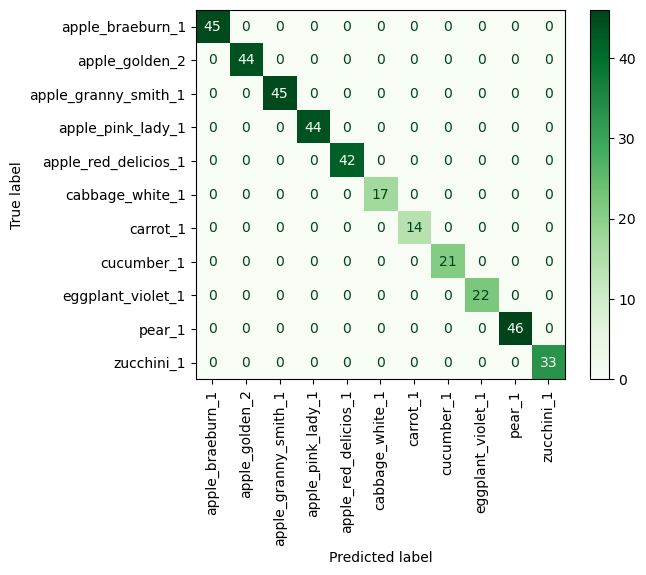

In [9]:
# Generate and display confusion matrix for test data with known labels
labels = list(unique_labels)
test_results = list(map(lambda x: list(unique_labels).index(x), test_labels))

conf_matrix = confusion_matrix(np.array(test_results), np.argmax(test_predictions, axis=1))

conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

conf_matrix_display.plot(cmap=plt.cm.Greens)
plt.xticks(rotation=90)
plt.show()

# User Supplied Data


Dropdown(description='Selected user file: ', index=2, options=('1534494.png', '1630518.png', '2387394.png', '2…

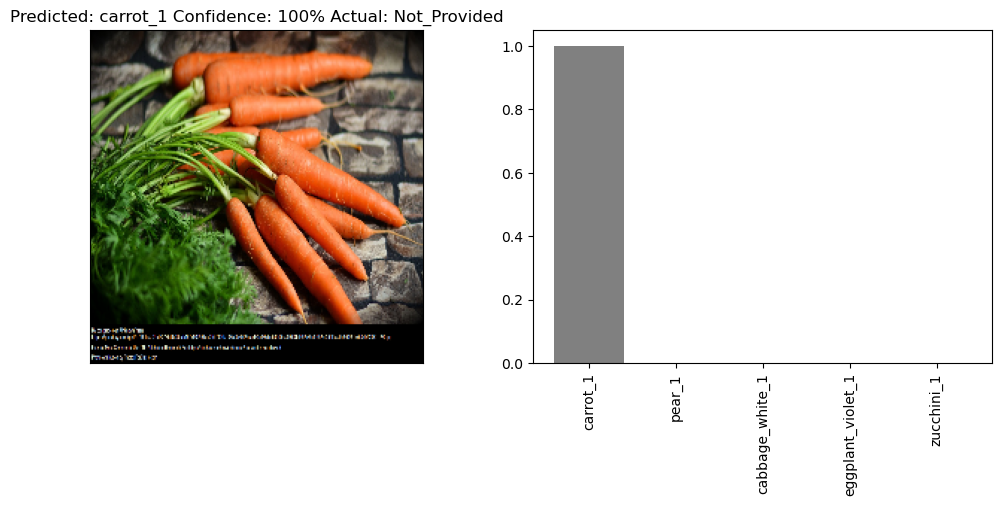

In [10]:
# Creates dropdown to select the user image result to show
selected_user_file = os.listdir(cwd + "\\user-submissions\\")[-1]
user_file_names = os.listdir(cwd + "\\user-submissions\\")

user_file_selector = widgets.Dropdown(
                        options=os.listdir(cwd + "\\user-submissions\\"),
                        value=os.listdir(cwd + "\\user-submissions\\")[-1],
                        description='Selected user file: ',
                        disabled=False,
                        style={'description_width': 'initial'})

def select_model(dropdown):
    clear_output()
    global selected_user_file
    selected_user_file = dropdown['owner'].value
    display(user_file_selector)
    display_prediction_analysis(user_predictions, user_image_tensors, user_file_names.index(selected_user_file))

display(user_file_selector)
user_file_selector.observe(select_model)
display_prediction_analysis(user_predictions, user_image_tensors, user_file_names.index(selected_user_file))